# Conditionnal Bernoulli

## question 1

`définition des objet`  
Let $N$ be a natural number, and consider the probability vector $p = (p_1, p_2, \dots, p_N)$ where each $p_i$ belongs to the interval $(0,1)$ for  $i = 1, \dots, N$.  
The sample space is given by $\Omega = \{0,1\}^N.$  
We assume that $I$ is an integer satisfying $I \leq \frac{N}{2}$.  
Let $g$ be the probability density function of the random vector  
$$
(X_1, \dots, X_N)
$$
where the $X_i$ are independent Bernoulli random variables $X_i \sim \mathsf{B}(p_i).$  
Finally, let $f$ be the probability density function of  
$$
(X_1, \dots, X_N) \sim \mathsf{CB}(p, I).
$$  

`justification du choix de ce que l'on fait`
We will use the following proposition from the lecture :
> Let $f$, $g$ be probability density functions (PDFs) such that the support of $g$ contains the support of $f$ and
> 
> $$
> f \leq M g \quad \text{with } M \geq 1.
> $$
> 
> ### Accept-Reject Algorithm
> Repeat:  
> 1. Draw $X \sim g$ and $U \sim U[0,1]$.  
> 2. Until $U \leq \frac{f(X)}{M g(X)}$.
> 
> ### Properties:
> - $X \sim f$ 
> - The number of draws until acceptance follows a **Geometric** distribution:  
>   
>   $$
>   \text{Geometric}(1/M).
>   $$  

This propriety can be used because $g$ does not cancel out `j'imagine que c'est comme ça que se dit ne s'annule pas` on $\Omega$.  
We choose the smallest possible $M$ in order to have as little draws as possible 
$$
M = \underset{x \in \Omega}{\sup} \; \frac{f(x)}{g(x)}
$$

### algorithm du cours aucun changement

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import geom

`on mettra sûrement la classe dans un fichier .py pour que ça soit plus lisible`

In [8]:
class RejectionSampling:
    def __init__(self, p, I):  # Default value for m
        self.p = p
        self.I = I
        self.N = len(p)
        self.g = self.pdf_bernoulli(p)  # Bernoulli probability function
        self.f = self.pdf_cb(p, I)  # Conditional probability function
        self.M = self.compute_M(self)  # Compute M
        self._sample = None
        self._acceptances = None
    
    @staticmethod
    def compute_M(self):
        """Computes M based on given m and probability ratios"""
        res = 1
        for seq in self.generate_sequences(self.N, self.I):  # Corrected N and I
            pr = self.f(seq) / self.g(seq)  # Fix missing self.
            if pr > res:
                res = pr
        return res

    def pdf_cb(self, p, I):
        """Computes a conditional probability function"""
        g = self.pdf_bernoulli(p)
        proba = 0
        for x in self.generate_sequences(len(p), I):
            proba += g(x)

        def f(x):
            return g(x) / proba if np.sum(x) == I else 0  # Use np.sum(x)

        return f

    @staticmethod
    def generate_sequences(N, I):
        """Generates all binary sequences of length N with I ones"""
        positions = itertools.combinations(range(N), I)
        sequences = []
        for pos in positions:
            seq = np.zeros(N, dtype=int)  # Start with all zeros
            seq[list(pos)] = 1  # Set the specified positions to 1
            sequences.append(seq)
        return np.array(sequences)

    @staticmethod
    def pdf_bernoulli(p):
        """Creates a Bernoulli probability function"""
        def g(x):
            return np.prod(np.where(x == 1, p, 1 - p))
        return g
    
    def sample(self,L=1):
        samples = []
        acceptances = []
        while len(samples) < L:
            attempt = 0
            while True:
                attempt += 1 
                X = np.array([np.random.binomial(1, p_i) for p_i in self.p])
                U = np.random.uniform(0,1)
                if U<=(self.f(X)/(self.g(X)*(self.M))):
                    samples.append(X)
                    acceptances.append(attempt)
                    break
        self._sample=np.array(samples)
        self._acceptances = np.array(acceptances)
    
    def plot_acceptance_density(self):
        """Plots the empirical density function and the theoretical Geometric(1/M) density."""
        if self._acceptances is None:
            print("No samples generated yet. Run sample() first.")
            return

        unique, counts = np.unique(self._acceptances, return_counts=True)
        empirical_density = counts / np.sum(counts)  # Normalize to get probability values

        # Theoretical geometric distribution with success probability 1/M
        k_values = np.arange(1, max(unique) + 1)  # Range of values for plotting
        theoretical_density = geom.pmf(k_values, 1 / self.M)  # Geometric PMF

        plt.figure(figsize=(8, 5))
        
        # Empirical density as a bar plot
        plt.bar(unique, empirical_density, width=0.8, color='b', alpha=0.7, edgecolor='black', label="Empirical Density")
        
        # Theoretical geometric density as a line plot
        plt.plot(k_values, theoretical_density, 'r-o', markersize=4, label=f"Theoretical Geom(1/{self.M:.2f})", linewidth=1)

        plt.xlabel("Number of Attempts Before Acceptance")
        plt.ylabel("Probability Density")
        plt.title("Empirical vs Theoretical Density of Acceptance Attempts")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

Pour $I$ fixer on va évaluer comment évolue $M$; pour ce fair on va considérer des $p_i$ uniforme sur $(0,1)$. On remarque que pour un $N$ donnée, $M$ va avoir des valeurs extrème essentiellement plus hautes que sa moyenne quartile etc.; pour plusieurs N, on va avoir une croissance des valeurs extrèmes M exponentielle; 

C:\Users\heini\AppData\Local\Temp\ipykernel_9084\3210251214.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


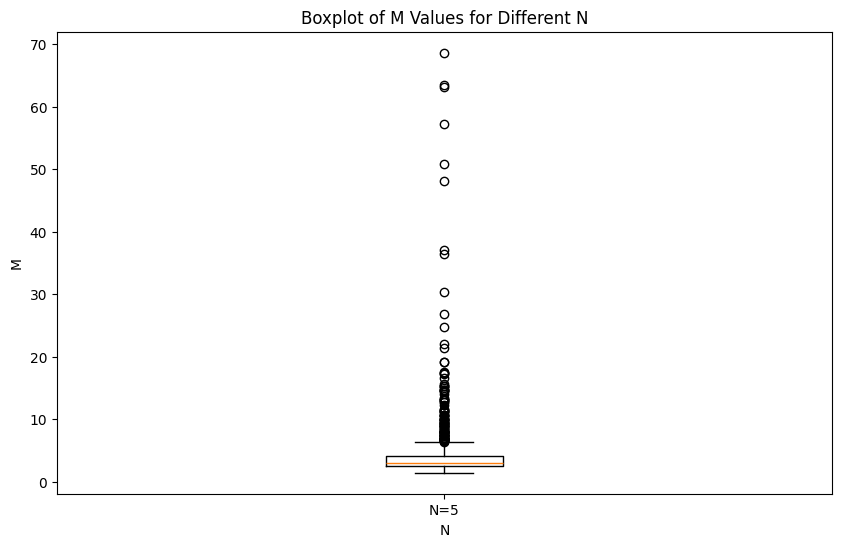

In [62]:
I = 2
num_samples = 1000  # Number of samples to run
N_values = [5]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

C:\Users\heini\AppData\Local\Temp\ipykernel_9084\2752977224.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


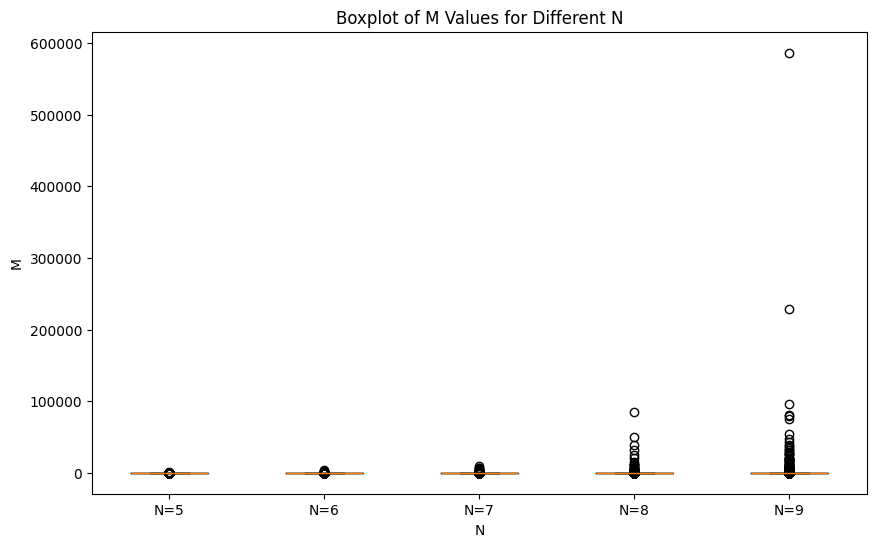

In [63]:
I = 2
num_samples = 10000  # Number of samples to run
N_values = [5,6,7,8,9]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()